# GWExPy TimeSeries 相互運用性 (Interop) チュートリアル

このノートブックでは、`gwexpy` の `TimeSeries` クラスに追加された新しい相互運用機能 (Interoperability Features) を紹介します。
`gwexpy` は、Pandas, Xarray, PyTorch, Astropy などの一般的なデータサイエンス・ライブラリとの間で、シームレスにデータを変換することができます。

Original TimeSeries:
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: demo_signal,
           channel: None)


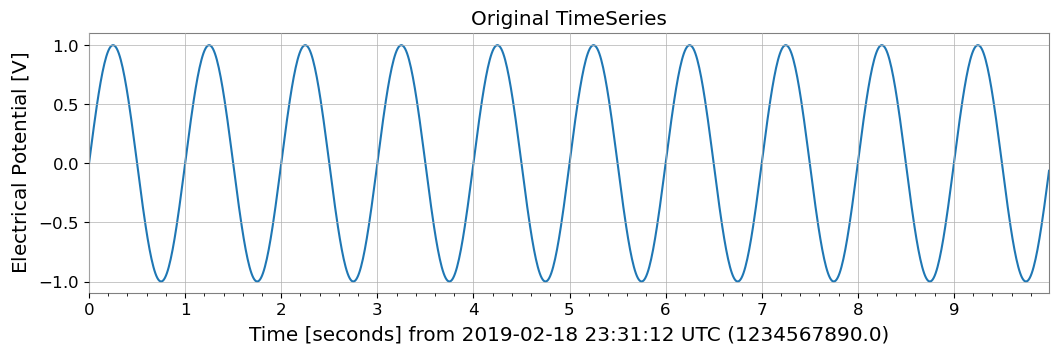

In [1]:
import sys
from pathlib import Path
import numpy as np
from astropy import units as u
from gwpy.time import LIGOTimeGPS
import matplotlib.pyplot as plt

from gwexpy.timeseries import TimeSeries

# サンプルデータの作成
# 10秒間、100Hzの正弦波データを生成します
rate = 100 * u.Hz
dt = 1 / rate
t0 = LIGOTimeGPS(1234567890, 0)
duration = 10 * u.s
size = int(rate * duration)
times = np.arange(size) * dt.value
data = np.sin(2 * np.pi * 1.0 * times)  # 1Hz sine wave

ts = TimeSeries(data, t0=t0, dt=dt, unit="V", name="demo_signal")
print("Original TimeSeries:")
print(ts)
ts.plot(title="Original TimeSeries");

## 1. Pandas との連携

`to_pandas()` メソッドを使うと、`TimeSeries` を `pandas.Series` に変換できます。
インデックスは `datetime` (UTC), `gps`, `seconds` (Unix timestamp) から選択可能です。


--- Converted to Pandas Series ---


time_utc
2019-02-18 23:31:49+00:00           0.000000
2019-02-18 23:31:49.010000+00:00    0.062791
2019-02-18 23:31:49.020000+00:00    0.125333
2019-02-18 23:31:49.030000+00:00    0.187381
2019-02-18 23:31:49.040000+00:00    0.248690
                                      ...   
2019-02-18 23:31:58.949991+00:00   -0.309017
2019-02-18 23:31:58.959991+00:00   -0.248690
2019-02-18 23:31:58.969990+00:00   -0.187381
2019-02-18 23:31:58.979990+00:00   -0.125333
2019-02-18 23:31:58.989990+00:00   -0.062791
Name: demo_signal, Length: 1000, dtype: float64

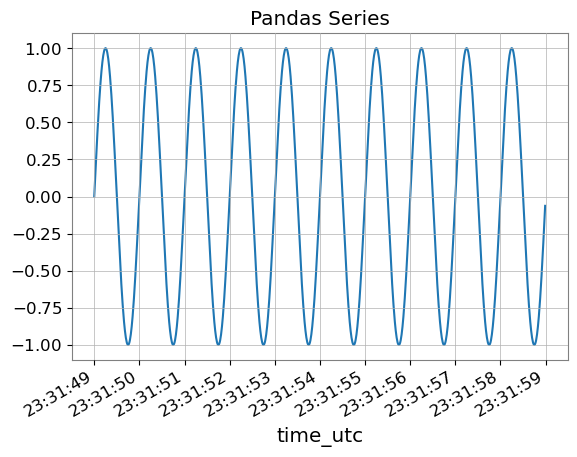


--- Restored TimeSeries from Pandas ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567927.0 s,
           dt: 0.00999999 s,
           name: demo_signal,
           channel: None)


In [2]:
try:
    # Pandas Series への変換 (デフォルトは datetime index)
    s_pd = ts.to_pandas(index="datetime")
    print("\n--- Converted to Pandas Series ---")
    display(s_pd)
    s_pd.plot(title="Pandas Series");
    plt.show()
    plt.close()
    
    # Pandas Series から TimeSeries への復元
    ts_restored = TimeSeries.from_pandas(s_pd, unit="V")
    print("\n--- Restored TimeSeries from Pandas ---")
    print(ts_restored)
    
except ImportError:
    print("Pandas is not installed.")

## 2. Xarray との連携

`xarray` は多次元のラベル付き配列を扱う強力なライブラリです。`to_xarray()` でメタデータを保持したまま変換できます。


--- Converted to Xarray DataArray ---
<xarray.DataArray 'demo_signal' (time: 1000)> Size: 8kB
array([ 0.        ,  0.06279052,  0.12533323, ..., -0.18738131,
       -0.12533323, -0.06279052])
Coordinates:
  * time     (time) datetime64[ns] 8kB 2019-02-18T23:31:49 ... 2019-02-18T23:...
Attributes:
    unit:        V
    name:        demo_signal
    channel:     None
    epoch:       1234567890.0
    time_coord:  datetime
Attributes: {'unit': 'V', 'name': 'demo_signal', 'channel': 'None', 'epoch': 1234567890.0, 'time_coord': 'datetime'}


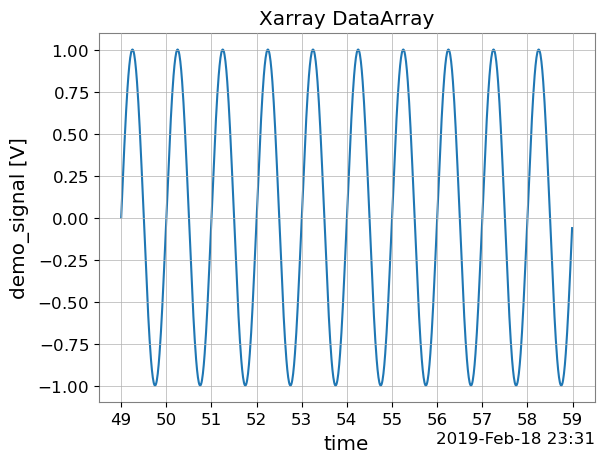


--- Restored TimeSeries from Xarray ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567927.0 s,
           dt: 0.009999990463256836 s,
           name: demo_signal,
           channel: None)


In [3]:
try:
    # Xarray DataArray への変換
    da = ts.to_xarray()
    print("\n--- Converted to Xarray DataArray ---")
    print(da)
    # メタデータ (attrs) が保持されているか確認
    print("Attributes:", da.attrs)
    
    da.plot();
    plt.title("Xarray DataArray")
    plt.show()
    plt.close()
    
    # 復元
    ts_x = TimeSeries.from_xarray(da)
    print("\n--- Restored TimeSeries from Xarray ---")
    print(ts_x)
    
except ImportError:
    print("Xarray is not installed.")

## 3. Astropy との連携

天文学分野で標準的な `astropy.timeseries.TimeSeries` との相互変換もサポートしています。


--- Converted to Astropy TimeSeries ---
     time            value       
------------- -------------------
 1234567890.0                 0.0
1234567890.01 0.06279051952931337
1234567890.02 0.12533323356430426
1234567890.03  0.1873813145857246
1234567890.04  0.2486898871648548


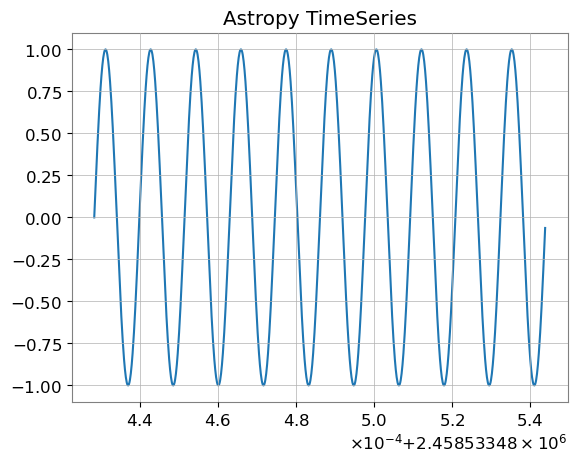


--- Restored from Astropy ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: dimensionless,
           t0: 1234567890.0 s,
           dt: 0.009999990463256836 s,
           name: None,
           channel: None)


In [4]:
try:
    # Astropy TimeSeries への変換
    ap_ts = ts.to_astropy_timeseries()
    print("\n--- Converted to Astropy TimeSeries ---")
    print(ap_ts[:5])
    fig, ax = plt.subplots()
    ax.plot(ap_ts.time.jd, ap_ts["value"]);
    plt.title("Astropy TimeSeries")
    plt.show()
    plt.close()
    
    # 復元
    ts_astro = TimeSeries.from_astropy_timeseries(ap_ts)
    print("\n--- Restored from Astropy ---")
    print(ts_astro)

except ImportError:
    print("Astropy is not installed.")

## 4. Obspy (地球物理学) との連携　


--- Converted to Obspy Trace ---
... | 2019-02-18T23:31:12.000000Z - 2019-02-18T23:31:21.990000Z | 100.0 Hz, 1000 samples


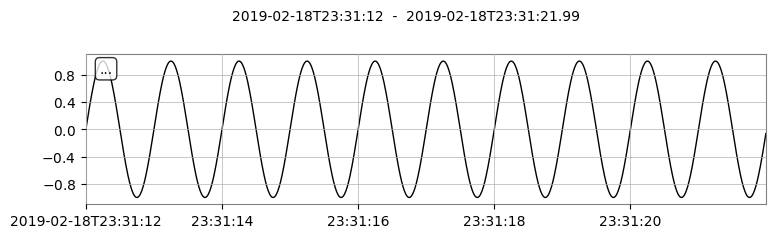

Recovered from Obspy: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: dimensionless,
           t0: 1234567890.0 s,
           dt: 0.01 s,
           name: ...,
           channel: None)


In [5]:
try:
    import obspy
    # Obspy Trace への変換
    trace = ts.to_obspy_trace()
    print("\n--- Converted to Obspy Trace ---")
    print(trace)
    trace.plot(title="Obspy Trace")
    plt.show()
    plt.close()
    
    # 復元
    ts_obs = TimeSeries.from_obspy_trace(trace)
    print("Recovered from Obspy:", ts_obs)
except ImportError:
    print("Obspy not installed.")



## 5. 音声処理ライブラリ (Librosa, Pydub) との連携


--- Converted for Librosa ---
y shape: (1000,), sr: 100.0
[ 0.          0.06279052  0.12533323 ... -0.18738131 -0.12533323
 -0.06279052] 100.0


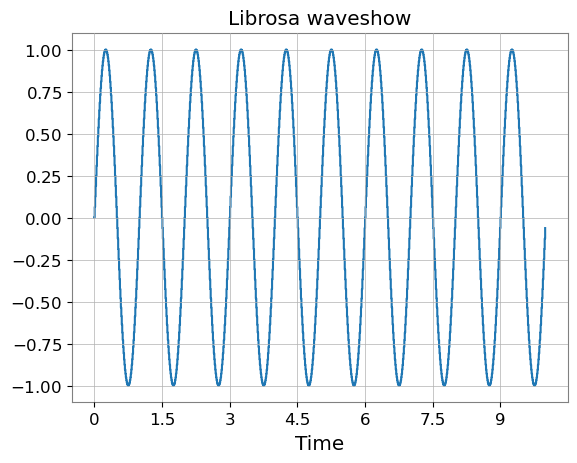

MFCC shape: (13, 2)

--- Converted to Pydub AudioSegment ---
Duration: 40000 ms
Channels: 1
Recovered from Pydub: TimeSeries([ 0,  0,  0, ..., -1, -1, -1]
           unit: dimensionless,
           t0: 0.0 s,
           dt: 0.01 s,
           name: None,
           channel: None)


/home/washimi/mambaforge/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1000
  warnings.warn(


In [6]:
try:
    import librosa
    import librosa.display
    # Librosa向けNumpy配列への変換 (float32)
    y = ts.to_librosa()
    sr = ts.sample_rate.to("Hz").value
    print("\n--- Converted for Librosa ---")
    print(f"y shape: {y.shape}, sr: {sr}")
    print(y,sr)
    librosa.display.waveshow(y=y, sr=sr);
    plt.title("Librosa waveshow")
    plt.show()
    plt.close()
    
    # MFCC特徴量の計算例
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    print(f"MFCC shape: {mfcc.shape}")
except ImportError:
    print("Librosa not installed.")

try:
    from pydub import AudioSegment
    # Pydub AudioSegment への変換
    seg = ts.to_pydub()
    print("\n--- Converted to Pydub AudioSegment ---")
    print(f"Duration: {len(seg)} ms")
    print(f"Channels: {seg.channels}")
    
    # 戻す
    ts_from_pydub = TimeSeries.from_pydub(seg)
    print("Recovered from Pydub:", ts_from_pydub)
except ImportError:
    print("Pydub not installed.")



## 6. MNE(生体信号) との連携

Using matplotlib as 2D backend.
Creating RawArray with float64 data, n_channels=1, n_times=1000
    Range : 0 ... 999 =      0.000 ...     9.990 secs
Ready.

--- Converted to MNE Raw ---
<RawArray | 1 x 1000 (10.0 s), ~14 KiB, data loaded>


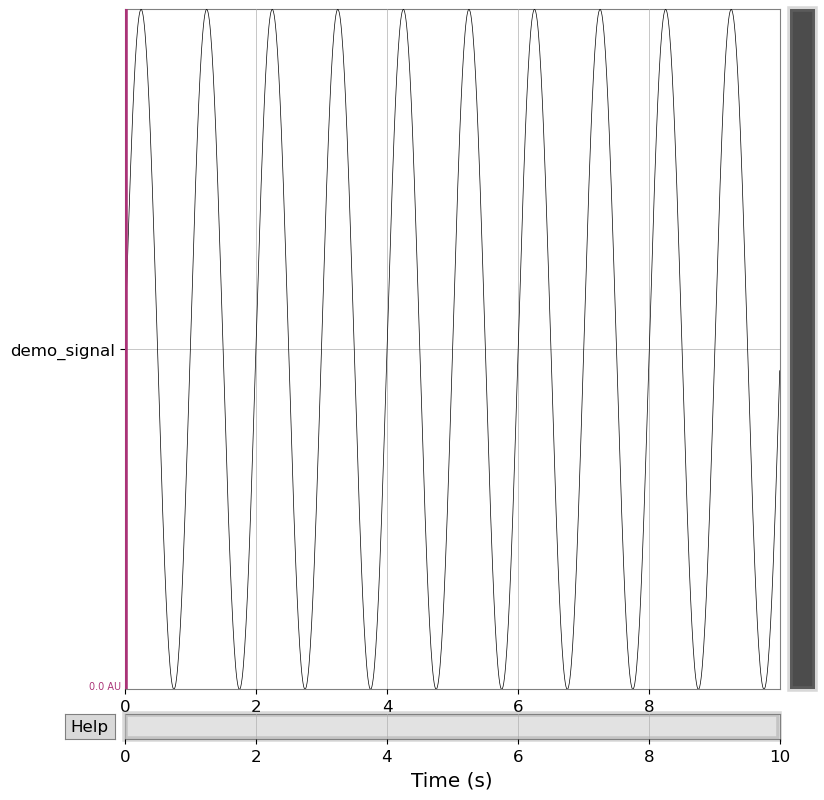

In [7]:
try:
    import mne
    mne.viz.set_browser_backend('matplotlib')
    # MNE RawArray への変換 (infoが必要になるため、簡易的な変換例)
    # 通常は TimeSeriesMatrix (多チャンネル) からの変換が一般的ですが、単一Chもサポート
    raw = ts.to_mne_raw()
    print("\n--- Converted to MNE Raw ---")
    print(raw)
    raw.plot();
    plt.show()
    plt.close()
except ImportError:
    print("MNE not installed.")

## 7. PyTorch との連携 (Deep Learning)

ディープラーニングの前処理として、`TimeSeries` を直接 `torch.Tensor` に変換できます。GPU転送も可能です。

In [8]:
try:
    import torch
    
    # PyTorch Tensor への変換
    tensor = ts.to_torch(dtype=torch.float32)
    print("\n--- Converted to PyTorch Tensor ---")
    print(f"Tensor shape: {tensor.shape}, dtype: {tensor.dtype}")
    
    # Tensor からの復元 (t0, dt は別途指定が必要)
    ts_torch = TimeSeries.from_torch(tensor, t0=ts.t0, dt=ts.dt, unit="V")
    print("\n--- Restored from Torch ---")
    print(ts_torch)
    
except ImportError:
    print("PyTorch is not installed.")


--- Converted to PyTorch Tensor ---
Tensor shape: torch.Size([1000]), dtype: torch.float32

--- Restored from Torch ---
TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


## 8. TensorFlow との連携

In [9]:
try:
    import tensorflow as tf
    # TensorFlow Tensor への変換
    tf_tensor = ts.to_tf()
    print("\n--- Converted to TensorFlow Tensor ---")
    print(f"Tensor shape: {tf_tensor.shape}")
    print(f"Tensor dtype: {tf_tensor.dtype}")
    
    # 戻す
    ts_from_tf = TimeSeries.from_tf(tf_tensor, t0=ts.t0, dt=ts.dt, unit=ts.unit)
    print("Recovered from TF:", ts_from_tf)
except ImportError:
    print("TensorFlow not installed.")



2025-12-21 17:16:09.199276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 17:16:09.262926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



--- Converted to TensorFlow Tensor ---
Tensor shape: (1000,)
Tensor dtype: <dtype: 'float64'>
Recovered from TF: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


2025-12-21 17:16:10.701689: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 9. JAX との連携

In [10]:
try:
    import jax
    import jax.numpy as jnp
    # JAX Array への変換
    jax_arr = ts.to_jax()
    print("\n--- Converted to JAX Array ---")
    print(f"Array shape: {jax_arr.shape}")
    
    # 戻す
    ts_from_jax = TimeSeries.from_jax(jax_arr, t0=ts.t0, dt=ts.dt, unit=ts.unit)
    print("Recovered from JAX:", ts_from_jax)
except ImportError:
    print("JAX not installed.")




--- Converted to JAX Array ---
Array shape: (1000,)
Recovered from JAX: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


## 10. Dask との連携 (大規模データ)

In [11]:
try:
    import dask.array as da
    # Dask Array への変換
    dask_arr = ts.to_dask(chunks='auto')
    print("\n--- Converted to Dask Array ---")
    print(dask_arr)
    
    # 戻す (compute=True で即座にロード)
    ts_from_dask = TimeSeries.from_dask(dask_arr, t0=ts.t0, dt=ts.dt, unit=ts.unit)
    print("Recovered from Dask:", ts_from_dask)
except ImportError:
    print("Dask not installed.")




--- Converted to Dask Array ---
dask.array<array, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Recovered from Dask: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 1 / Hz,
           dt: 0.01 1 / Hz,
           name: None,
           channel: None)


## Zarr への保存と読み込み

In [12]:
try:
    import zarr
    import tempfile
    import shutil
    
    # 一時ディレクトリにZarrストアを作成
    with tempfile.TemporaryDirectory() as tmpdir:
        store_path = f"{tmpdir}/example.zarr"
        store = zarr.DirectoryStore(store_path)
        
        # Zarrへ保存
        ts.to_zarr(store, path='my_timeseries', overwrite=True)
        print("\n--- Saved to Zarr ---")
        
        # Zarrから読み込み
        ts_from_zarr = TimeSeries.from_zarr(store, path='my_timeseries')
        print("Loaded from Zarr:", ts_from_zarr)
        
except ImportError:
    print("Zarr not installed.")




--- Saved to Zarr ---
Loaded from Zarr: TimeSeries([ 0.        ,  0.06279052,  0.12533323, ...,
            -0.18738131, -0.12533323, -0.06279052]
           unit: V,
           t0: 1234567890.0 s,
           dt: 0.01 s,
           name: demo_signal,
           channel: None)


## まとめ

これらの機能により、GWExPyはデータの「ハブ」として機能し、解析、機械学習、可視化などの多様なタスクに対して柔軟に対応できるようになりました。